In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

"""
CODE TO EXTRACT DATA FROM XML FILE
"""

# Description  
__author__ = 'Maylis Layan'
__creation_date__ = '2021-02-07' 
__last_update__ = '2020-02-'

# Import libraries
from os import listdir
from os.path import isfile, join, abspath
import sys
import re
import pandas as pd
import numpy as np
import dendropy as dp
from pathlib import Path
from lxml import *
from io import StringIO
from Bio import SeqIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from datetime import datetime, timedelta
from math import ceil
import matplotlib.pyplot as plt

# Import local modules
sys.path.append('/home/maylayan/MMMI_Rage/Python_modules/')
#sys.path.insert(0, abspath('/home/mlaya/MMMI_Rage/Python_modules/'))
from mathFunctions import * 
from geneticAndSpatialEstimates import *

## Change directory
os.chdir('/home/maylayan/MMMI_Rage/Real_data/sars_cov_2')
regions = ["Africa", "Americas", "Asia", "China", "Europe", "Oceania"]
geneticParams = ['kappa','gammaShape','pInv','clockRate']
burnIn = 0.1
mrst = 2020.175
allresults = list()

In [ ]:
#####################################################
# Load DTA
#####################################################
allDta = list()
for d in ["dta", "dta2", "dta3"]:
    temp_dta = pd.read_csv("dta/sars_cov_2_" + d + ".log.txt", sep = "\t", comment = "#")
    b = math.ceil(temp_dta.shape[0] * burnIn)
    temp_dta = temp_dta.iloc[b:temp_dta.shape[0]]
    allDta.append(temp_dta)
dta = pd.concat(allDta).reset_index(drop=True)
stepInterval = dta['state'].iloc[1] - dta['state'].iloc[0]

# Rename columns
dta = renameColumns(dta, "dta", "sars_cov_2")
dta.rename(columns = {"alpha":"gammaShape"}, inplace=True)
dta.columns = dta.columns.str.replace("c_counts", "nMigration").str.replace("\[1\]|c_", '', regex = True)
dta.columns = dta.columns.str.replace("continent.rates.", "forwards_", regex = False)
dta.columns = dta.columns.str.replace("continent.indicators.", "indicators_", regex = False)
dta.columns = dta.columns.str.replace("\.", "_", regex = True)

# Write root age distribution
rootAge = dta[["state", "ageRoot"]].copy()
rootAge.state = "dta"
rootAge.rename(columns={"state":"model"}).to_csv("figures/ageroot_dta.txt", sep ="\t", index=False)

# Write genetic parameter distribution
geneticParams_df = dta[geneticParams].copy()
geneticParams_df["model"] = "dta"
pd.melt(geneticParams_df, id_vars=["model"], value_vars=geneticParams, 
        var_name="parameter", value_name='value').to_csv("figures/geneticparams_dta.txt", sep ="\t", index=False)


# Write total migration events to file
posteriorDistnMig(dta, "dta").to_csv("figures/distribution_dta.txt", sep="\t", index=False)

# Dataframe with the root location
dtaRootLocation = dta[['continent']].reset_index(drop=True)
dtaRootLocation = dtaRootLocation.rename(columns={"continent":"rootLocation"})
dta.drop(columns=['continent'], inplace = True)

# Summary statistics
results = dta.drop(columns=['state']).describe(percentiles = [0.025, 0.5, 0.975]).transpose(copy = True)
results.drop(['count'], axis = 1, inplace = True)

# ESS of all continuous parameters 
# Migration rates are excluded when BSSVS is implemented
discrete_or_rates = [x for x in dta.columns if x in ["state", "allTransitions", "continent_nonZeroRates", "continent_count"]] + \
                    [x for x in dta.columns if "indicators" in x or "nMigration" in x or "forwards" in x]
results['ESS'] = dta.drop(columns=discrete_or_rates).apply(
    lambda x: ESS(x, stepInterval)
    )

# 95% HPD intervals 
results['2_5_hpd'] = dta.drop(columns=['state']).apply(
    lambda x: hpd(x, lower_only = True)
    ) 
results['97_5_hpd'] = dta.drop(columns=['state']).apply(
    lambda x: hpd(x, upper_only = True)
    )

# Change results index
results['parameter'] = results.index
results.reset_index(inplace = True, drop = True)

##############################################
# Deal with spatial data when BSSVS is 
# implemented and compute conditional ess  
##############################################
bssvsResults = bssvsStatistics(dta, len(regions), False, "dta", stepInterval, "true")
results = pd.concat([results, bssvsResults], sort = False, ignore_index = True) 

# Remove lines corresponding to raw migration rates
results = results[~results.parameter.str.match(r'^backwards_.*$|^forwards_.*$|^nMigration_.*$')]
results.reset_index(inplace = True, drop = True)

##############################################
# Add root location if wanted
##############################################
rootResults = rootLocationAnalysis(None, "dta/", "dta", regions, dtaRootLocation, dict(zip(regions, regions)), 10)

results = pd.concat([results, rootResults], sort = False, ignore_index = True)
results.rename(columns={"2.5%":"2_5", "97.5%":"97_5", "50%":"50"}, inplace = True)

##############################################
# verify ESS values
##############################################
nLow = sum(~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna()))
if nLow:
    print(results[~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna())])

results["model"] = "dta"
results.to_csv("figures/output_dta.txt", sep="\t", index=False)
dta.to_csv("figures/posterior_dta.txt", sep ="\t", index=False)
#allresults.append(results)

In [ ]:
##############################################
# Plot supported MJ
##############################################
mj = results[(results.parameter.str.contains("nMigration")) & (results.BF >= 3)]
mj["97_5_hpd"] = mj["97_5_hpd"] - mj["50"]
mj["2_5_hpd"] = mj["50"] - mj["2_5_hpd"]

plt.style.use('default')
fig, ax = plt.subplots()

plotline1, caplines1, barlinecols1 = ax.errorbar([x.replace("bssvs_nMigration_", "") for x in mj["parameter"]], 
            mj["50"].tolist(), 
            mj["2_5_hpd"].tolist(), ecolor = "orange",
            lolims = True,  fmt='o', linewidth=2, capsize=6)
caplines1[0].set_marker('_')

plotline2, caplines2, barlinecols2 = ax.errorbar([x.replace("bssvs_nMigration_", "") for x in mj["parameter"]], 
            mj["50"].tolist(), 
            mj["97_5_hpd"].tolist(),
            ecolor = "orange", uplims = True,  fmt='o', linewidth=2, capsize=6)
caplines2[0].set_marker('_')
plt.xticks(rotation=45,ha='right')

plt.show()


In [ ]:
#####################################################
# Load BASTA
#####################################################
allBasta = list()

for d in ["basta1", "basta2", "basta3"]:
    temp_basta = pd.read_csv("basta/sars_cov_2_" + d + ".log.txt", sep = "\t", comment = "#")
    b = math.ceil(temp_basta.shape[0] * burnIn)
    temp_basta = temp_basta.iloc[b:temp_basta.shape[0]]
    allBasta.append(temp_basta)

basta = pd.concat(allBasta).reset_index(drop=True)
stepInterval = basta['Sample'].iloc[1] - basta['Sample'].iloc[0]

# Remove burn in and rename columns
basta.columns = basta.columns.str.replace("proportionInvariant.s:sars_cov_2", "pInv", regex=False)
basta.columns = basta.columns.str.replace("gammaShape.s:sars_cov_2", "gammaShape", regex = False)
bastaRegionDict = {"0":"Africa", "1":"Americas", "2":"Asia", "3": "China", "4":"Europe", "5":"Oceania"}
basta = renameColumns(basta, "basta", "sars_cov_2", bastaRegionDict)
basta = forwardsRates(basta, "forwards", "basta")

# Write genetic parameter distribution
geneticParams_df = basta[geneticParams].copy()
geneticParams_df["model"] = "basta"
pd.melt(geneticParams_df, id_vars=["model"], value_vars=geneticParams, 
        var_name="parameter", value_name='value').to_csv("figures/geneticparams_basta.txt", sep ="\t", index=False)
# Write total migration events to file
posteriorDistnMig(basta, "basta").to_csv("figures/distribution_basta.txt", sep="\t", index=False)

# Dataframe with the root location
bastaRootLocation = basta[['rootLocation']].reset_index(drop=True)
basta.drop(columns = ["rootLocation"], inplace = True)

# Sumamry statistics
results = basta.drop(columns=['state']).describe(percentiles = [0.025, 0.5, 0.975]).transpose(copy = True)
results.drop(['count'], axis = 1, inplace = True)

# ESS of all continuous parameters 
# Migration rates are excluded when BSSVS is implemented
discrete_or_rates = [x for x in basta.columns if x in ["state"]] + \
                    [x for x in basta.columns if "indicators" in x or "nMigration" in x or 'backwards' in x]
results['ESS'] = basta.drop(columns=discrete_or_rates).apply(
    lambda x: ESS(x, stepInterval)
    )

# 95% HPD intervals 
results['2_5_hpd'] = basta.drop(columns=['state']).apply(
    lambda x: hpd(x, lower_only = True)
    ) 
results['97_5_hpd'] = basta.drop(columns=['state']).apply(
    lambda x: hpd(x, upper_only = True)
    )

# Change results index
results['parameter'] = results.index
results.reset_index(inplace = True, drop = True)

##############################################
# Deal with spatial data when BSSVS is 
# implemented and compute conditional ess  
##############################################
bssvsResults = bssvsStatistics(basta, len(regions), False, "basta", stepInterval, "all")
results = pd.concat([results, bssvsResults], sort = False, ignore_index = True) 

# Remove lines corresponding to raw migration rates
results = results[~results.parameter.str.match(r'^backwards_.*$|^forwards_.*$|^nMigration_.*$')]
results.reset_index(inplace = True, drop = True)

##############################################
# Add root location if wanted
##############################################
rootResults = rootLocationAnalysis(None, "basta/", "basta", regions, bastaRootLocation, dict(zip(regions, regions)), 10)
results = pd.concat([results, rootResults], sort = False, ignore_index = True)
results.rename(columns={"2.5%":"2_5", "97.5%":"97_5", "50%":"50"}, inplace = True)

##############################################
# verify ESS values
##############################################
nLow = sum(~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna()))
if nLow:
    print(results[~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna())])

results["model"]= "basta"
results.to_csv("figures/output_basta.txt", sep="\t", index=False)
basta.to_csv("figures/posterior_basta.txt", sep ="\t", index=False)
#allresults.append(results)

In [ ]:
#####################################################
# Separate post burn-in trees according to 
# the mode of the tree prior
#####################################################
majMode = dp.TreeList()
minMode = dp.TreeList()

for d in ["basta1", "basta2", "basta3"]:
    temp_basta = pd.read_csv("basta/sars_cov_2_" + d + ".log.txt", sep = "\t", comment = "#")
    b = math.ceil(temp_basta.shape[0] * burnIn)
    
    treeY = dp.Tree.yield_from_files(
        files = ["basta/sars_cov_2_" + d+ ".trees.txt"],
        schema = 'nexus',  
        preserve_underscores = True,  
        extract_comment_metadata = True,
        rooting = 'default-rooted'
    )
    
    for i, tree in enumerate(treeY):
        if i >= b and i < temp_basta.shape[0] and temp_basta["mutationRate"].iloc[i] >= 11e-4:
            majMode.append(tree)
        
        if i >= b and i < temp_basta.shape[0]  and temp_basta["mutationRate"].iloc[i] <= 10e-4:
            minMode.append(tree)

majMode.write(path="basta/sars_cov_2_basta_majmode.trees.txt", schema="nexus")
minMode.write(path="basta/sars_cov_2_basta_minmode.trees.txt", schema="nexus")

In [ ]:
##############################################
# Plot supported MJ
##############################################
mj = results[(results.parameter.str.contains("nMigration")) & (results.BF >= 3)]
mj["97_5_hpd"] = mj["97_5_hpd"] - mj["50"]
mj["2_5_hpd"] = mj["50"] - mj["2_5_hpd"]

plt.style.use('default')
fig, ax = plt.subplots()

plotline1, caplines1, barlinecols1 = ax.errorbar([x.replace("bssvs_nMigration_", "") for x in mj["parameter"]], 
            mj["50"].tolist(), 
            mj["2_5_hpd"].tolist(), ecolor = "orange",
            lolims = True,  fmt='o', linewidth=2, capsize=6)
caplines1[0].set_marker('_')

plotline2, caplines2, barlinecols2 = ax.errorbar([x.replace("bssvs_nMigration_", "") for x in mj["parameter"]], 
            mj["50"].tolist(), 
            mj["97_5_hpd"].tolist(),
            ecolor = "orange", uplims = True,  fmt='o', linewidth=2, capsize=6)
caplines2[0].set_marker('_')
plt.xticks(rotation=45,ha='right')

plt.show()

In [ ]:
#####################################################
# Merge basta trees from posterior distribution
#####################################################
treeList = dp.TreeList()
ageRoot = []
files = [
        "basta/sars_cov_2_basta1.trees.txt", 
        "basta/sars_cov_2_basta2.trees.txt",
        "basta/sars_cov_2_basta3.trees.txt"
    ]

for f in files:
    treeY = dp.Tree.yield_from_files(
        files = [f],
        schema = 'nexus',  
        preserve_underscores = True,  
        extract_comment_metadata = True,
        rooting = 'default-rooted'
    )
    
    """
    if "basta2" in f:
        b = 444
    else:
        b = 101
    """
    
    for i, tree in enumerate(treeY):
        if i >= b:
            treeList.append(tree)
            ageRoot.append(mrst - max(tree.calc_node_ages(is_force_max_age =True)))


treeList.write(path="basta/sars_cov_2_basta_all.trees.txt", schema="nexus")
pd.DataFrame({"model":"basta","ageRoot":ageRoot}).to_csv("figures/ageroot_basta.txt", sep ="\t", index=False)
#mcc = treeList.maximum_product_of_split_support_tree()
#mcc.write_to_path("basta/sars_cov_2_basta.mcc.tree", "nexus")

In [ ]:
#####################################################
# Load MASCOT
#####################################################
allMascot = list()
mascotFiles = ["mascot1", "mascot2", "mascot3"]

for d in mascotFiles:
    temp_mascot = pd.read_csv("mascot/sars_cov_2_" + d + ".log.txt", sep = "\t", comment = "#")
    b = math.ceil(temp_mascot.shape[0] * burnIn)
    temp_mascot = temp_mascot.iloc[b:temp_mascot.shape[0]]
    allMascot.append(temp_mascot)

mascot = pd.concat(allMascot).reset_index(drop=True)
mascot.rename(columns={"proportionInvariant":"pInv", 
                       "Sample":"state",
                       "treeLikelihood.sars_cov_2": "treeLikelihood",
                       "sum(indicatorsConstantBSSVS_)": "sumNonZeroRates"
                      }, inplace=True)
stepInterval = mascot['state'].iloc[1] - mascot['state'].iloc[0]

# Remove burn in and rename columns
mascot.columns = mascot.columns.str.replace("migrationEvents", "nMigration", regex = False)
mascot.columns = mascot.columns.str.replace("b_migration", "backwards", regex = False)
mascot.columns = mascot.columns.str.replace("to_", "", regex = False)
mascot.columns = mascot.columns.str.replace(".", "_", regex = False)
mascot = forwardsRates(mascot, "forwards", "mascot")

# Write root age distribution
rootAge = mascot[["state", "TreeHeight"]].copy()
rootAge.TreeHeight = mrst - rootAge.TreeHeight
rootAge.state = "mascot"
rootAge.rename(columns={"state":"model", "TreeHeight":"ageRoot"}).to_csv("figures/ageroot_mascot.txt", sep ="\t", index=False)

# Write genetic parameter distribution
geneticParams_df = mascot[geneticParams].copy()
geneticParams_df["model"] = "mascot"
pd.melt(geneticParams_df, id_vars=["model"], value_vars=geneticParams, 
        var_name="parameter", value_name='value').to_csv(
    "figures/geneticparams_mascot.txt", sep ="\t", index=False)

# Write total migration events to file
posteriorDistnMig(mascot, "mascot").to_csv("figures/distribution_mascot.txt", 
                                           sep="\t", index=False)

# Summary statistics
results = mascot.drop(columns=['state']).describe(percentiles = [0.025, 0.5, 0.975]).transpose(copy = True)
results.drop(['count'], axis = 1, inplace = True)

# ESS of all continuous parameters 
# Migration rates are excluded when BSSVS is implemented
discrete_or_rates = [x for x in mascot.columns if x in ["state", "sumNonZeroRates", "nrMigrationEvents"]] + \
                    [x for x in mascot.columns if "nMigration" in x or 'backwards' in x]
results['ESS'] = mascot.drop(columns=discrete_or_rates).apply(
    lambda x: ESS(x, stepInterval)
    )

# 95% HPD intervals 
results['2_5_hpd'] = mascot.drop(columns=['state']).apply(
    lambda x: hpd(x, lower_only = True)
    ) 
results['97_5_hpd'] = mascot.drop(columns=['state']).apply(
    lambda x: hpd(x, upper_only = True)
    )

# Change results index
results['parameter'] = results.index
results.reset_index(inplace = True, drop = True)

##############################################
# Deal with spatial data when BSSVS is 
# implemented and compute conditional ess  
##############################################
bssvsResults = bssvsStatistics(mascot, len(regions), False, "mascot", stepInterval, "all")
results = pd.concat([results, bssvsResults], sort = False, ignore_index = True) 

# Remove lines corresponding to raw migration rates
results = results[~results.parameter.str.match(r'^backwards_.*$|^forwards_.*$|^nMigration_.*$')]
results.reset_index(inplace = True, drop = True)

# Root location
ann = annotationDict["mascot"]
rootLocation = []
for x in mascotFiles:
    treeCollectionYielder = dp.Tree.yield_from_files(
        files = ["mascot/sars_cov_2_" + x + ".trees.txt"], 
        schema = 'nexus',  
        preserve_underscores = True,  
        extract_comment_metadata = True
    )
    
    for i, tree in enumerate(treeCollectionYielder):
        if i >= b:
            rootLocation.append(tree.seed_node.annotations.get_value(name=ann))

resultsRoot = pd.DataFrame(pd.Series(rootLocation).value_counts() / len(rootLocation) )
resultsRoot.reset_index(inplace=True)
resultsRoot.columns = ["parameter", "value"]

if resultsRoot.shape[0] != len(regions):
    for x in regions:
        if x not in list(resultsRoot.parameter):
            resultsRoot = resultsRoot.append(pd.DataFrame({'parameter':[x], 'value':[0.0]}), ignore_index = True)

resultsRoot.parameter = 'root_' + resultsRoot.parameter.astype(str)
kl = KLRootPrediction(resultsRoot.value, len(regions), True)
resultsRoot = resultsRoot.append(pd.DataFrame({"parameter": ["KL"], "value": [kl]}), ignore_index = True)

results = pd.concat([results, rootResults], sort = False, ignore_index = True)
results.rename(columns={"2.5%":"2_5", "97.5%":"97_5", "50%":"50"}, inplace = True)

##############################################
# verify ESS values
##############################################
nLow = sum(~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna()))
if nLow:
    print(results[~results.ESS.isna() & results.ESS < 200 & (results.BF >=3 | results.BF.isna())])

results["model"]= "mascot"
results.to_csv("figures/output_mascot.txt", sep="\t", index=False)
mascot.to_csv("figures/posterior_mascot.txt", sep ="\t", index=False)
#allresults.append(results)

In [ ]:
##############################################
# Create full tree posterior distribution
##############################################
treeList = dp.TreeList()

for x in mascotFiles:
    treeList2 = dp.TreeList()
    treeCollectionYielder = dp.Tree.yield_from_files(
        files = ["mascot/sars_cov_2_" + x + ".trees.txt"], 
        schema = 'nexus',  
        preserve_underscores = True,  
        extract_comment_metadata = True,
        rooting = 'default-rooted'
    )
    
    logFile = pd.read_csv("mascot/sars_cov_2_" + x + ".log.txt", comment='#', sep="\t")
    b = math.ceil(logFile.shape[0] * burnIn / 100)
    
    for i, tree in enumerate(treeCollectionYielder):
        if i > b:
            treeList.append(removeUnifurcations(tree))
            #treeList2.append(removeUnifurcations(tree))
    #treeList2.write(path="mascot/sars_cov_2_" + x + "_nob.trees.txt", schema = "nexus")
            
treeList.write(path="mascot/sars_cov_2_mascot_full.trees.txt", schema="nexus")

In [2]:
#####################################################
# Load MASCOT-GLM
#####################################################
# Log file
allresults = []
for g in ["glm_wid"]: 
    allGlm = list()
    glmFiles = [g.replace("glm_", "") + str(i) for i in range(1,4)]

    for d in glmFiles:
        temp_glm = pd.read_csv(g + "/sars_cov_2_" + d + ".log.txt", sep = "\t", comment = "#")
        b = math.ceil(temp_glm.shape[0] * burnIn)
        temp_glm = temp_glm.iloc[b:temp_glm.shape[0]]
        allGlm.append(temp_glm)
    log = pd.concat(allGlm).reset_index(drop=True)

    stepInterval = log['Sample'].iloc[1] - log['Sample'].iloc[0]

    # Remove Ne.Region columns
    toDrop = [x for x in log.columns if "Ne." in x]
    log.drop(columns=toDrop, inplace=True)

    # Rename columns
    log.rename(columns={
        "Sample":"state",
        "sum(NeIndicatorGLM.)":"sumNePredNonZero", 
        "sum(migrationIndicatorGLM.)":"sumMigPredNonZero", 
        "proportionInvariant": "pInv", 
        "treeLikelihood.sars_cov_2": "treeLikelihood"
        }, inplace = True)
    log.columns = log.columns.str.replace("migrationEvents", "nMigration", regex = False)
    log.columns = log.columns.str.replace("mig.", "forwards_", regex = False)
    log.columns = log.columns.str.replace("to_", "", regex = False)
    log.columns = log.columns.str.replace(".", "_", regex = False)
    scalers = log.filter(regex=("scaler_.*"))
    log.drop(columns=[x for x in log.columns if "scaler" in x], inplace = True)
    
    # Write root age distribution
    rootAge = log[["state", "TreeHeight"]].copy()
    rootAge.TreeHeight = mrst - rootAge.TreeHeight
    rootAge.state = g
    rootAge.rename(columns={"state":"model", "TreeHeight":"ageRoot"}).to_csv(
        "figures/ageroot_" + g + ".txt", sep ="\t", index=False)

    # Write genetic parameter distribution
    geneticParams_df = log[geneticParams].copy()
    geneticParams_df["model"] = g
    pd.melt(geneticParams_df, id_vars=["model"], value_vars=geneticParams, 
            var_name="parameter", value_name='value').to_csv(
        "figures/geneticparams_" + g + ".txt", sep ="\t", index=False)

    # Write total migration events to file
    posteriorDistnMig(log, g).to_csv("figures/distribution_" + g+ ".txt", sep="\t", index=False)
    
    ##############################################
    # Summary statistics and ESS of all parameters
    ##############################################
    # Summary statistics (min, mean, median, max, 95% CI)
    results = log.drop(columns=['state']).describe(percentiles = 
        [0.025, 0.5, 0.975]).transpose(copy = True)
    results.drop(['count'], axis = 1, inplace = True)

    # ESS of all continuous parameters 
    # Migration rates are excluded when BSSVS is implemented
    discrete_or_rates = [x for x in log.columns if x in ["state", "sumMigPredNonZero", "sumNePredNonZero", "nrMigrationEvents"]] + \
                        [x for x in log.columns if "nMigration" in x]

    results['ESS'] = log.drop(columns=discrete_or_rates).apply(
        lambda x: ESS(x, stepInterval)
        )

    # 95% HPD intervals 
    results['2_5_hpd'] = log.drop(columns=['state']).apply(
        lambda x: hpd(x, lower_only = True)
        ) 
    results['97_5_hpd'] = log.drop(columns=['state']).apply(
        lambda x: hpd(x, upper_only = True)
        )

    # Change results index
    results['parameter'] = results.index
    results.reset_index(inplace = True, drop = True)

    # Inclusion of probabilities derived from scalers
    results_scalers = scalers.apply(lambda x: 1-mean(x==0)).to_frame().reset_index()
    results_scalers.columns = ["parameter", "inclusion_prob"]
    results_scalers.parameter = results_scalers.parameter.str.replace("scaler_", "").replace("Ne", "NeGLM_Clock")

    # Merge sum stats and inclusion probabilities
    results = results.merge(results_scalers, how="outer", on = "parameter")

    ##############################################
    # Add root location and write full 
    # posterior tree distribution without burn-in
    ##############################################
    ann = annotationDict["mascot"]
    rootLocation = []
    treePostDist = dp.TreeList()

    for x in glmFiles:
        treeCollectionYielder = dp.Tree.yield_from_files(
            files = [g + "/sars_cov_2_" + x + ".trees.txt"], 
            schema = 'nexus',  
            preserve_underscores = True,  
            extract_comment_metadata = True
        )

        for i, tree in enumerate(treeCollectionYielder):
            if i >= b:
                rootLocation.append(tree.seed_node.annotations.get_value(name=ann))
                treePostDist.append(removeUnifurcations(tree))

    treePostDist.write(path= g + "/sars_cov_2_" + g + "_full.trees.txt", schema="nexus")
    resultsRoot = pd.DataFrame(pd.Series(rootLocation).value_counts() / len(rootLocation) )
    resultsRoot.reset_index(inplace=True)
    resultsRoot.columns = ["parameter", "value"]

    if resultsRoot.shape[0] != len(regions):
        for x in regions:
            if x not in list(resultsRoot.parameter):
                resultsRoot = resultsRoot.append(pd.DataFrame({'parameter':[x], 'value':[0.0]}), 
                                                 ignore_index = True)

    resultsRoot.parameter = 'root_' + resultsRoot.parameter.astype(str)
    kl = KLRootPrediction(resultsRoot.value, len(regions), True)
    resultsRoot = resultsRoot.append(pd.DataFrame({"parameter": ["KL"], "value": [kl]}), 
                                     ignore_index = True)

    results = pd.concat([results, resultsRoot], sort = False, ignore_index = True)

    results.rename(columns={"2.5%":"2_5", "97.5%":"97_5", "50%":"50"}, inplace = True)
    results["model"]= g
    results.to_csv("figures/output_" + g + ".txt", sep = "\t", index=False)
    log.to_csv("figures/posterior_"+ g +".txt", sep ="\t", index=False)
    #allresults.append(results)    

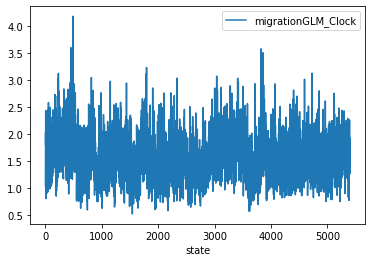

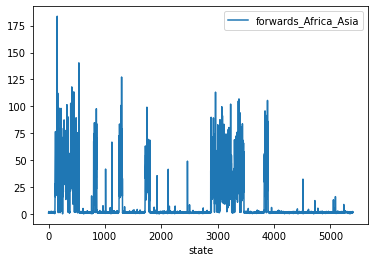

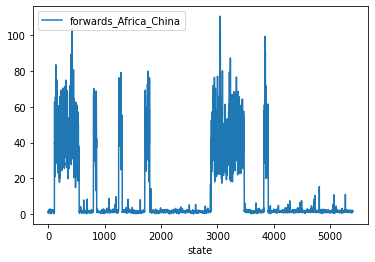

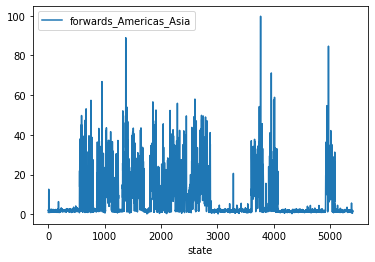

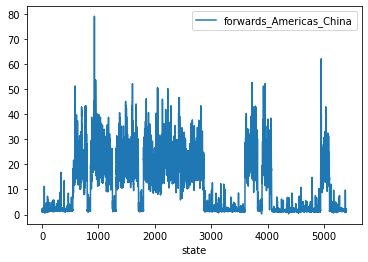

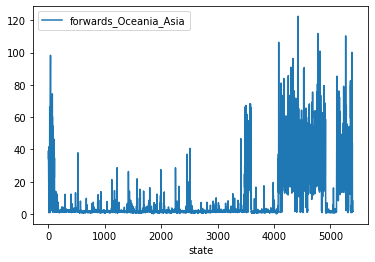

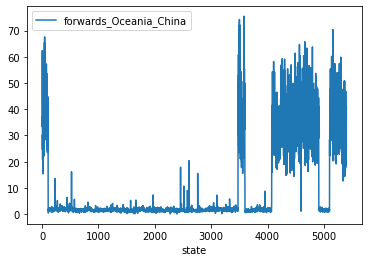

In [3]:
import matplotlib.pyplot as plt
log.state = range(log.shape[0])
toPlot = results.parameter[round(results.ESS) < 200].tolist()
for y in toPlot:
    log.plot(x="state", y=[y])
    plt.show()

In [6]:
results[results.ESS < 200]

,mean,std,min,2_5,50,97_5,max,ESS,2_5_hpd,97_5_hpd,parameter,inclusion_prob,value,model
10,1.539779,0.411803,0.522390,0.860486,1.495674,2.465988,4.188104,178.518033,0.799028,2.345854,migrationGLM_Clock,NaN,NaN,glm_wid
13,10.003496,19.024206,0.082621,0.822654,1.572880,66.028865,183.737209,24.433235,0.155478,53.428429,forwards_Africa_Asia,NaN,NaN,glm_wid
14,11.207105,18.520341,0.186131,0.829304,1.589219,58.948326,110.499120,16.969028,0.231775,51.886003,forwards_Africa_China,NaN,NaN,glm_wid
18,8.963259,10.606002,0.175588,1.024080,2.140581,35.269570,99.767109,36.308851,0.602719,30.445817,forwards_Americas_Asia,NaN,NaN,glm_wid
19,12.531383,11.223413,0.234951,1.114506,12.725591,35.347174,79.198004,14.782718,0.807666,31.142700,forwards_Americas_China,NaN,NaN,glm_wid
23,1.508417,0.448338,0.070885,0.701853,1.478972,2.472639,4.410207,174.635674,0.668184,2.423696,forwards_Asia_Americas,NaN,NaN,glm_wid
24,2.101249,5.441204,0.171310,0.831031,1.505807,3.023504,132.043414,183.906286,0.709632,2.570804,forwards_Asia_China,NaN,NaN,glm_wid
39,8.871845,15.806754,0.107798,0.848326,1.659873,54.512330,122.478688,9.400735,0.107798,44.633306,forwards_Oceania_Asia,NaN,NaN,glm_wid
40,8.935284,14.646826,0.076904,0.840656,1.648890,46.531029,70.369446,7.493927,0.537412,41.963341,forwards_Oceania_China,NaN,NaN,glm_wid
